<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/Text_classificaion_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates text classification using Convolutional Neural Networks (CNNs)

In [1]:
#Get data
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2023-07-29 23:44:24--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  5.44MB/s    in 0.9s    

2023-07-29 23:44:26 (5.44 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv("bbc_text_cls.csv")
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
# convert the targets to categorical
df['target'] = df['labels'].astype('category').cat.codes

In [5]:
df.head()

,text,labels,target
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0


In [6]:
# slit dataet
df_train, df_test = train_test_split(df, test_size = 0.3)

In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 28020 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (1557, 3468)


In [10]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3468)


In [13]:
# number of classes
K = df['target'].max() + 1
K

5

In [14]:
# Create the model

# We get to choose embedding dimensionality
D = 50

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3468)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 3468, 50)          1401050   
                                                                 
 conv1d_3 (Conv1D)           (None, 3466, 32)          4832      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1155, 32)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 1153, 64)          6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 384, 64)          0         
 1D)                                                         

In [18]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['target'],
  epochs=50,
  validation_data=(data_test, df_test['target'])
)

Training model...
Epoch 1/50
49/49 [==============================] - 26s 298ms/step - loss: 1.6004 - accuracy: 0.2209 - val_loss: 1.5930 - val_accuracy: 0.3563
Epoch 2/50
49/49 [==============================] - 8s 167ms/step - loss: 1.4735 - accuracy: 0.3751 - val_loss: 1.1934 - val_accuracy: 0.5719
Epoch 3/50
49/49 [==============================] - 8s 159ms/step - loss: 0.5933 - accuracy: 0.8542 - val_loss: 0.3376 - val_accuracy: 0.8787
Epoch 4/50
49/49 [==============================] - 5s 96ms/step - loss: 0.0777 - accuracy: 0.9788 - val_loss: 0.1561 - val_accuracy: 0.9551
Epoch 5/50
49/49 [==============================] - 5s 99ms/step - loss: 0.0159 - accuracy: 0.9968 - val_loss: 0.1393 - val_accuracy: 0.9536
Epoch 6/50
49/49 [==============================] - 5s 100ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9551
Epoch 7/50
49/49 [==============================] - 3s 65ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1357 - val_accurac

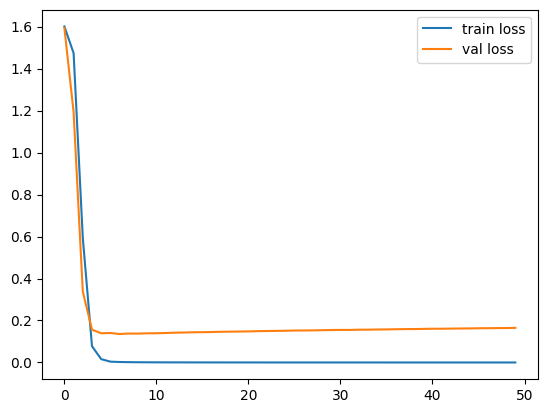

In [19]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

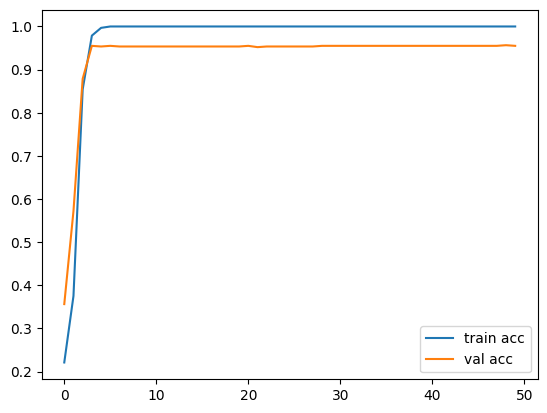

In [20]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();